Created on Thu Nov 21 19:35:37 2024 @author: hanna.dunska

# Step 1. Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
from pathlib import Path
from tempfile import TemporaryDirectory
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Enables the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
# Effective when input sizes for the network do not vary.
cudnn.benchmark = True

plt.ion()   # interactive mode

import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Step 2. Check device and configure for training

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps") # for MAC
else:
    device = torch.device("cpu") 

# Step 3. Define data augmentation and normalization for training and validation

In [3]:
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Experimenting with adding more noise to the input data, but it’s worsening the model performance

# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomRotation(20),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Step 4. Load data and split into train and validation sets

In [4]:
data_dir = '/Users/hanna.dunska/Desktop/Deep Learning/Homework/HW6_data/'

train_dir = os.path.join(data_dir, 'seg_train')
val_dir = os.path.join(data_dir, 'seg_val')

# Create the folder for val_data
Path(val_dir).mkdir(parents=True, exist_ok=True)

# Splitting the data on train and valid
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    
    # Separating the files by folders
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
        
        # Creating the `seg_val` folder
        val_class_dir = os.path.join(val_dir, class_name)
        Path(val_class_dir).mkdir(parents=True, exist_ok=True)
        
        # Moving files to `seg_val` folder
        for val_image in val_images:
            shutil.move(os.path.join(class_path, val_image), os.path.join(val_class_dir, val_image))

print("Data successfully split into 'seg_train' and 'seg_val'.")

Data successfully split into 'seg_train' and 'seg_val'.


# Step 5. Define datasets and dataloaders

In [5]:
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'seg_train'), transform=train_transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'seg_val'), transform=val_test_transform),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'seg_test'), transform=val_test_transform),
}

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=0),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=0),
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'val': len(image_datasets['val']),
    'test': len(image_datasets['test']),
}


class_names = image_datasets['train'].classes

print("Dataset sizes:")
print(dataset_sizes)

print("Class names:")
print(class_names)

Dataset sizes:
{'train': 11224, 'val': 2810, 'test': 3000}
Class names:
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# Step 6. Define helper function to visualize data transformations

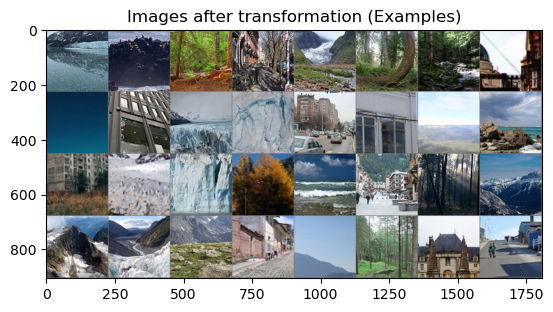

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # Imagenet mean
    std = np.array([0.229, 0.224, 0.225]) # Imagenet std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title="Images after transformation (Examples)")

# Step 7. Define the training and testing function

In [7]:

def train_and_test_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    metrics_history = {
        'train_loss': [],
        'val_loss': [],
        'test_loss': [],
        'train_acc': [],
        'val_acc': [],
        'test_acc': [],
        'train_f1': [],
        'val_f1': [],
        'test_f1': []
    }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                all_preds = []
                all_labels = []

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Collect predictions and labels for F1 score
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]
                epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
                
                if phase == 'train':
                    metrics_history['train_loss'].append(epoch_loss)
                    metrics_history['train_acc'].append(epoch_acc.item())  # Convert tensor to float
                    metrics_history['train_f1'].append(epoch_f1)
                elif phase == 'val':
                    metrics_history['val_loss'].append(epoch_loss)
                    metrics_history['val_acc'].append(epoch_acc.item())
                    metrics_history['val_f1'].append(epoch_f1)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        # Combine train and val datasets
        print("Fine-tuning the model on the full training dataset...")
        full_train_dataset = torch.utils.data.ConcatDataset([image_datasets['train'], image_datasets['val']])
        full_train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=32, shuffle=True, num_workers=0)
        
        # Reinitialize dataloader for fine-tuning
        model.train()
        for epoch in range(num_epochs // 2):  # Optional: Fine-tune for fewer epochs
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in full_train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    loss.backward()
                    optimizer.step()

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(full_train_dataset)
            epoch_acc = running_corrects.float() / len(full_train_dataset)
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f'Fine-tune Epoch {epoch+1}/{num_epochs // 2} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
        
        print("Fine-tuning complete. Evaluating on the test set...")
        model.eval()
        test_loss = 0.0
        test_corrects = 0
        all_preds = []
        all_labels = []

        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

        test_loss /= dataset_sizes['test']
        test_acc = test_corrects.float() / dataset_sizes['test']
        test_f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f} F1: {test_f1:.4f}')

    return model, metrics_history

# Step 8. Visualize predictions from the model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Step 9. Load pretrained ResNet18 and modify for classification

In [9]:
model_conv = torchvision.models.resnet18(weights='DEFAULT') #changed from IMAGENET1K_V1 to DEFAULT 

for param in model_conv.parameters(): 
    param.requires_grad = False

# Experimenting with unfreezing one more layer,  but it has no affect on model performance.
# for name, param in model_conv.named_parameters():
#     if 'layer4' in name or 'fc' in name:  # Layer4 - additional ResNet layer to unfreeze
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
        
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)
model_conv = model_conv.to(device)

# Step 10. Define loss, optimizer, and scheduler

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.AdamW(model_conv.fc.parameters(), lr=1e-03, weight_decay=1e-02) # switched to AdamW
scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=1, gamma=0.1)

# Step 11. Train, test, and visualize the model

Epoch 1/10
----------
train Loss: 0.6456 Acc: 0.7762 F1: 0.7761
val Loss: 0.3312 Acc: 0.8886 F1: 0.8887

Epoch 2/10
----------
train Loss: 0.4474 Acc: 0.8392 F1: 0.8390
val Loss: 0.3035 Acc: 0.8900 F1: 0.8887

Epoch 3/10
----------
train Loss: 0.4222 Acc: 0.8430 F1: 0.8429
val Loss: 0.2796 Acc: 0.9071 F1: 0.9067

Epoch 4/10
----------
train Loss: 0.4204 Acc: 0.8386 F1: 0.8384
val Loss: 0.2821 Acc: 0.9025 F1: 0.9017

Epoch 5/10
----------
train Loss: 0.4180 Acc: 0.8465 F1: 0.8463
val Loss: 0.2698 Acc: 0.9096 F1: 0.9092

Epoch 6/10
----------
train Loss: 0.4108 Acc: 0.8489 F1: 0.8486
val Loss: 0.2707 Acc: 0.9089 F1: 0.9088

Epoch 7/10
----------
train Loss: 0.4001 Acc: 0.8540 F1: 0.8538
val Loss: 0.2852 Acc: 0.9014 F1: 0.9004

Epoch 8/10
----------
train Loss: 0.3983 Acc: 0.8501 F1: 0.8500
val Loss: 0.2845 Acc: 0.9043 F1: 0.9034

Epoch 9/10
----------
train Loss: 0.4056 Acc: 0.8458 F1: 0.8456
val Loss: 0.2606 Acc: 0.9132 F1: 0.9129

Epoch 10/10
----------
train Loss: 0.3890 Acc: 0.8537 F

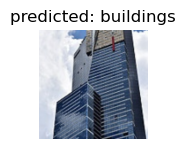

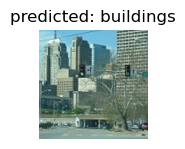

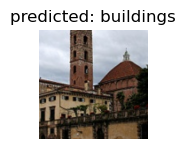

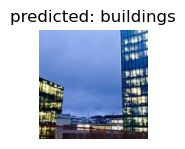

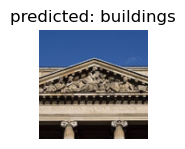

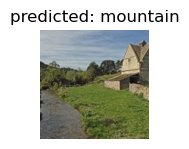

In [11]:
model_conv, metrics_history = train_and_test_model(
    model_conv, criterion, optimizer_conv, scheduler, num_epochs=10
)

visualize_model(model_conv, num_images=6)

# Step 12. Plot learning curves

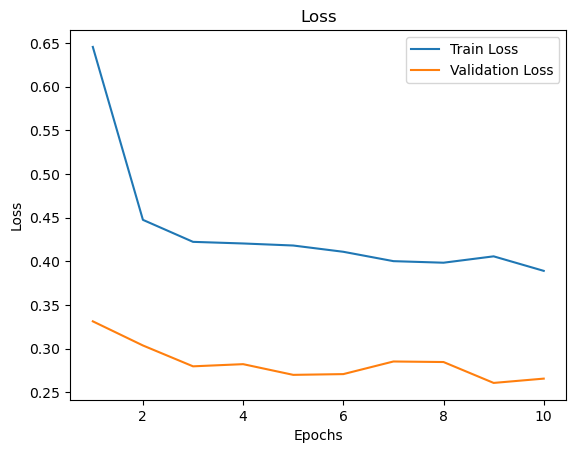

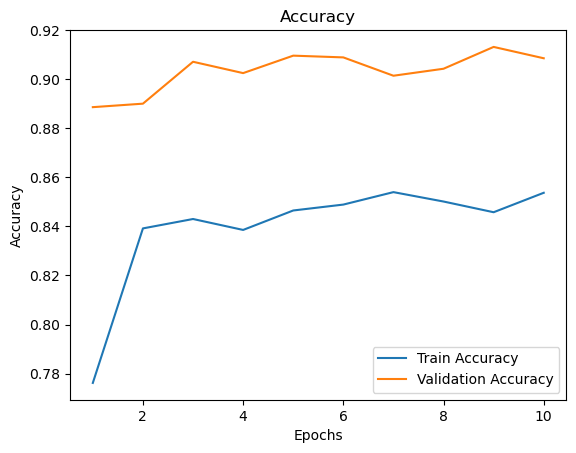

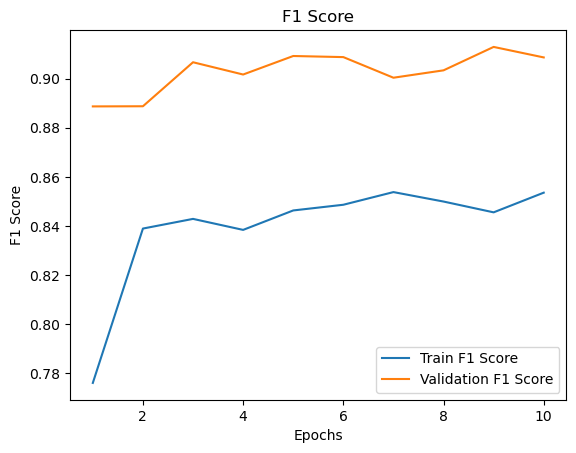

In [12]:
def plot_learning_curves(metrics_history):
    epochs = range(1, len(metrics_history['train_loss']) + 1)
    # Loss
    plt.figure()
    plt.plot(epochs, metrics_history['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics_history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(epochs, metrics_history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, metrics_history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # F1 Score
    plt.figure()
    plt.plot(epochs, metrics_history['train_f1'], label='Train F1 Score')
    plt.plot(epochs, metrics_history['val_f1'], label='Validation F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

# Plotting
plot_learning_curves(metrics_history)


# Step 13. Conclusion

## Why I`ve Selected F1 Score, Accuracy, and Loss
### F1 Score
F1 is a balanced metric that takes into account both precision and recall. It is particularly useful for evaluating models in multi-class classification tasks because it captures the balance between correctly classified examples of each class and the errors. If one class dominates the dataset, the model might achieve high precision by favoring that class, while ignoring minority classes. F1 helps to identify and mitigate such imbalances, ensuring that all classes are evaluated fairly.

### Accuracy
Accuracy provides a straightforward and intuitive measure of the proportion of correctly predicted examples out of the total number of samples. For most classification problems, accuracy remains a baseline metric that gives a general understanding of the model's performance. It is especially useful when the dataset is relatively balanced and when the goal is to measure the overall success of the model.

### Loss
Loss measures how far the model's predictions deviate from the true values. It plays a critical role during the training process, as it directly drives the optimization. Loss helps us monitor the learning process and detect potential issues, such as overfitting or underfitting, before they manifest in the final metrics. While accuracy and F1 are useful for evaluating a trained model, loss is invaluable for observing and guiding the training process.

### Why Not Use Confusion Matrix?
For a task with 6 classes, a confusion matrix would be a 6x6 table, making it less convenient for analyzing the overall performance of the model. While it is highly useful for detailed error analysis (e.g., identifying which classes are frequently misclassified as others), it does not provide a high-level understanding of the model's performance. If needed, a confusion matrix can be generated later for deeper analysis of specific misclassification patterns. However, it is more appropriate as a supplementary tool rather than a primary evaluation metric at this stage.

## Key Observations
### Training Loss and Accuracy:
The training accuracy improves and stabilizes around 84-85%, which suggests the model is performing reasonably well on the training data.

### Validation Loss and Accuracy:
The validation accuracy hovers around 91%, which is higher than the training accuracy.

### F1 Scores:
Validation F1 stabilizes around 0.91, in line with the accuracy trends.

## Potential Problems:

### Plateauing Performance: 
Both training and validation metrics seem to plateau after a few epochs (around epochs 3-4). While this isn't necessarily bad, it indicates that the model has reached its capacity to learn with the current setup (architecture, hyperparameters, or data).

### Training vs. Validation Gap: 
Validation accuracy and F1 are consistently higher than training accuracy and F1.

### Learning Saturation: 
The model appears to converge too early (around epoch 4). This suggests the learning rate also might be too high, or the optimizer has converged too quickly.


## Actions I`ve taken to Improve Performance:

### Data Augmentation: 
I've tried to add more diverse augmentations to the training set (e.g., random scaling, rotations, or even slight noise injections), and it's worsening the performance. However, it could help reduce the gap between training and validation scores, which could provide a more stable solution for new data, even with slightly lower performance.

### Hyperparameter Improvements:
 - The ResNet18 weights were changed from IMAGENET1K_V1 to DEFAULT. The DEFAULT weights in torchvision are typically tuned to be the most robust and up-to-date pretraining weights for transfer learning tasks. This makes them a better choice for initializing the model compared to older weight sets like IMAGENET1K_V1, which may have been trained under less optimized conditions.
 - The Adam optimizer was replaced with AdamW for increased flexibility. AdamW helps avoid overfitting by applying weight decay correctly.  It allows for better fine-tuning parameters without impacting the optimization dynamics.

### Experiments with Layers:
I've tried unfreezing one more layer in my model, but it had no effect on performance. This could be because the library model is already well-trained.

## The Further Possible Improvements:
1. Adding more augmentations could decrease the model's performance but may make it more stable for new data.
2. Experimenting with more advanced learning rate schedulers could help the model converge more effectively during later epochs.
3. As our learning seems to stop too early, trying a deeper model, like ResNet-50, might be beneficial. 
4. Improving the dataset split through cross-validation could make our metrics more representative.
5. Training for more epochs might also help. The model shows slight improvement even after epoch 6, so additional training with a deeper model and a better learning rate scheduler could yield benefits.
